# Emoji generator using GAN.
Addapted from Keras Minimal Viable GAN

In [1]:
# !pip install tqdm
# !pip install --upgrade pip         # pip 19.0 or higher is required for TF 2
# !pip install --upgrade setuptools  # Otherwise you'll get annoying warnings about bad installs
# !pip install --user --upgrade tensorflow-gpu

In [1]:
import imageio
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm  # progress bars

# Building on Keras
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras import initializers

np.random.seed(10)
random_dim = 100


Using TensorFlow backend.


In [2]:
tf.__version__

'2.1.0'

In [3]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:2', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:3', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [4]:
def discriminator_batch(generator, batch_size):
    files = iter(os.listdir('people_emoji_final'))
    while True:
        fake_images, images = [], []
        try:
            for _ in range(batch_size):
                file = next(files)
                image = np.array(imageio.imread(os.path.join('people_emoji_final', file)))
                image = image / 255
                image.resize((3888,))
                images.append(image)

                noise = np.random.normal(0, 1, size=[1, random_dim])
                fake_image = generator.predict(noise)
                fake_image.resize((3888,))
                fake_images.append(fake_image)

        except StopIteration:
            files = iter(os.listdir('people_emoji_final'))
            for _ in range(batch_size - len(images)):
                noise = np.random.normal(0, 1, size=[1, random_dim])
                fake_image = generator.predict(noise)
                fake_image.resize((3888,))
                fake_images.append(fake_image)

                file = next(files)
                image = np.array(imageio.imread(os.path.join('people_emoji_final', file)))
                image = image / 255
                image.resize((3888,))
                images.append(image)
        np.random.shuffle(images)
        imgs = np.concatenate([images, fake_images])
        zeros = np.zeros(batch_size * 2)
        zeros[:batch_size] = 0.9
        yield imgs, zeros

def generator_batch(batch_size):
    files = iter(os.listdir('people_emoji_final'))
    while True:
        try:
            images = []
            for _ in range(batch_size):
                file = next(files)
                image = np.array(imageio.imread(os.path.join('people_emoji_final', file)))
                image = image / 255
                image.resize((3888,))
                images.append(image)
        except StopIteration:
            files = iter(os.listdir('people_emoji_final'))
            for _ in range(batch_size - len(images)):
                file = next(files)
                image = np.array(imageio.imread(os.path.join('people_emoji_final', file)))
                image = image / 255
                image.resize((3888,))
                images.append(image)
        np.random.shuffle(images)
        noise = np.random.normal(0, 1, size=[batch_size, random_dim])
        yield noise, np.array(images)

def gan_batch(batch_size):
    while True:
        noise = np.random.normal(0, 1, size=[batch_size, random_dim])
        ones = np.ones(batch_size)
        yield noise, ones

def discriminator_pretrain_batch(batch_size):
    files = iter(os.listdir('people_emoji_final'))
    while True:
        try:
            images = []
            for _ in range(batch_size):
                file = next(files)
                image = np.array(imageio.imread(os.path.join('people_emoji_final', file)))
                image = image / 255
                image.resize((3888,))
                images.append(image)
        except StopIteration:
            files = iter(os.listdir('people_emoji_final'))
            for _ in range(batch_size - len(images)):
                file = next(files)
                image = np.array(imageio.imread(os.path.join('people_emoji_final', file)))
                image = image / 255
                image.resize((3888,))
                images.append(image)
        np.random.shuffle(images)
        y_dis = np.zeros(2 * batch_size)
        y_dis[:batch_size] = 0.9
        noise = np.random.normal(0, 1, size=[batch_size, 3888])
        X = np.concatenate([images, noise])
        yield X, y_dis


In [5]:
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=3888,
                            kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

#     discriminator.add(Dense(256))
#     discriminator.add(LeakyReLU(0.2))
#     discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim,
                        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(524))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1048))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(3888, activation='tanh'))
    generator.compile(loss='categorical_crossentropy', optimizer=optimizer)
    return generator

def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the 
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real/not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan



In [6]:
def plot_losses(epochs, disc_losses: list, gen_losses: list):
    plt.plot(np.linspace(0, epochs, len(disc_losses)), disc_losses, label='disc')
    plt.plot(np.linspace(0, epochs, len(gen_losses)), gen_losses, label='gen')
    plt.title('Loss per epoch.')
    plt.legend()
    plt.show()

In [13]:
 def plot_generated_images(epoch, generator, examples=10, figsize=(15, 15)):
    dim = (examples//10, 10)
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 36, 36, 3)
 
    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow((generated_images[i] * 255).astype(np.uint8), interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [8]:
def train(epochs=1, pretrain_epochs=1, batch_size=32):
    gen_losses = []
    disc_losses = []
    pretrain_losses = []

    # Build our GAN netowrk
    gen_adam = Adam(lr=0.0002, beta_1=0.5)
    disc_adam = Adam(lr=0.0002, beta_1=0.5)
    gan_adam = Adam(lr=0.0002, beta_1=0.5)

    gen_batch = generator_batch(batch_size)
    g_batch = gan_batch(batch_size)
    generator = get_generator(gen_adam)

    disp_batch = discriminator_pretrain_batch(batch_size)
    discriminator = get_discriminator(disc_adam)
    
    # Pre-train generator and discriminator.
    for e in tqdm(range(1, pretrain_epochs + 1)):
        pretrain_loss = generator.train_on_batch(*next(gen_batch))
        if e % 20 == 0:
            pretrain_losses.append(pretrain_loss)
#         discriminator.trainable = True
#         discriminator.train_on_batch(*next(disp_batch))
    
    plt.plot(np.linspace(0, pretrain_epochs, len(pretrain_losses)), pretrain_losses)
    plt.title('Generator pretrain loss by epoch.')
    plt.show()
    
    dis_batch = discriminator_batch(generator, batch_size)
    gan = get_gan_network(discriminator, random_dim, generator, gan_adam)

    # Train GAN.
    for e in tqdm(range(1, epochs + 1)):

        # Train discriminator
        if e % 2 == 0:
            discriminator.trainable = True
            disc_loss = discriminator.train_on_batch(*next(dis_batch))
            if e % 50 == 0:
                disc_losses.append(disc_loss)

        # Train generator
        discriminator.trainable = False
        gen_loss = gan.train_on_batch(*next(g_batch))
        if e % 50 == 0:
            gen_losses.append(gen_loss)

        if e % 1000 == 0:
            plot_generated_images(e, generator)
    return generator, disc_losses, gen_losses

In [69]:
pretrain_epochs = 2500
epochs = 25000

100%|██████████| 2500/2500 [02:18<00:00, 18.06it/s]


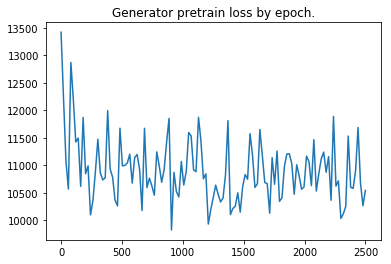

 84%|████████▍ | 20998/25000 [29:54<05:37, 11.87it/s] /home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
100%|██████████| 25000/25000 [35:38<00:00, 11.69it/s]


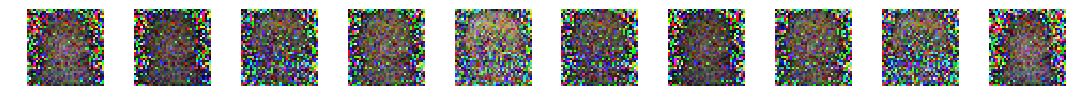

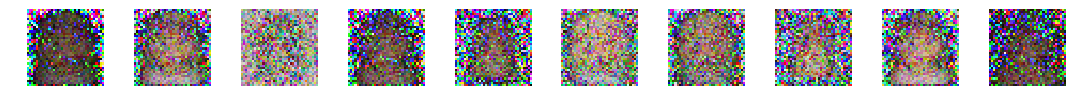

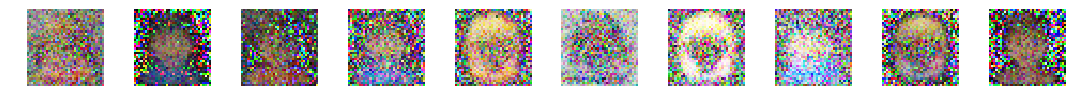

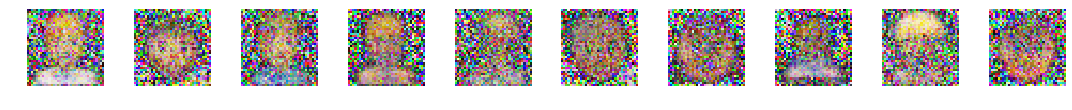

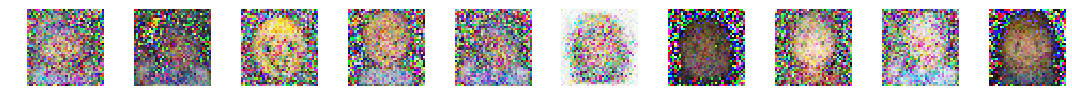

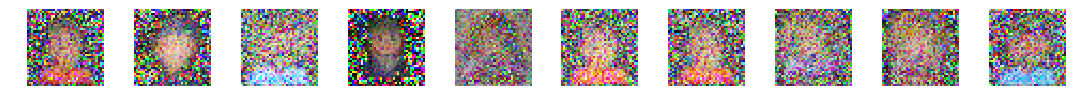

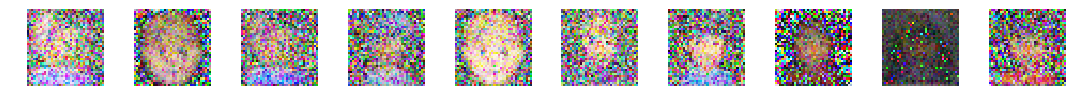

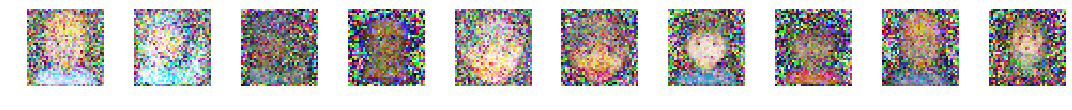

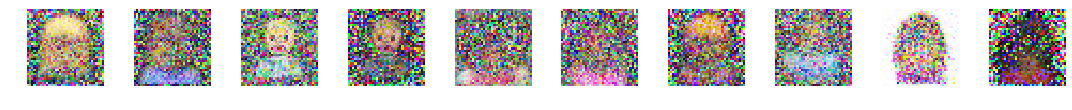

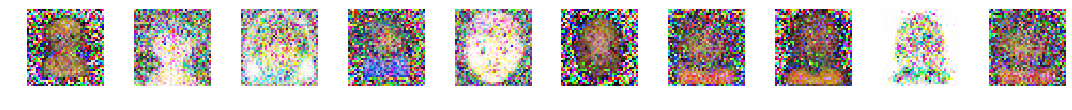

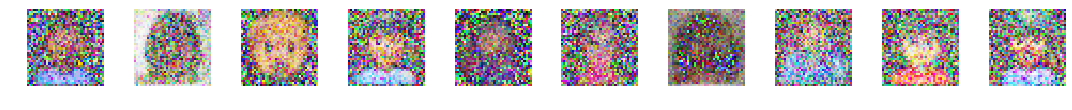

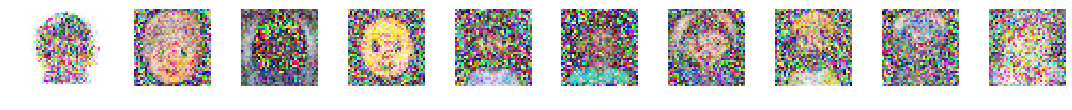

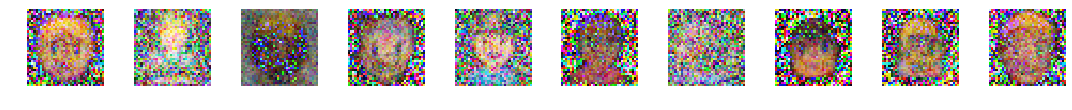

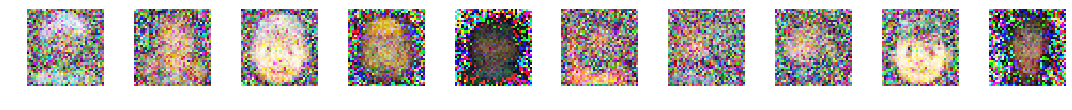

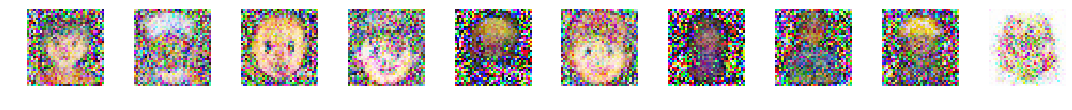

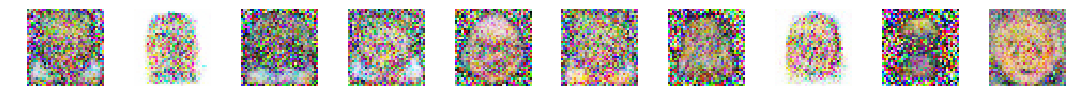

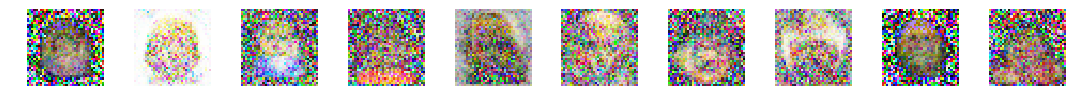

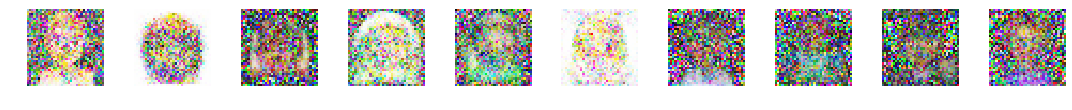

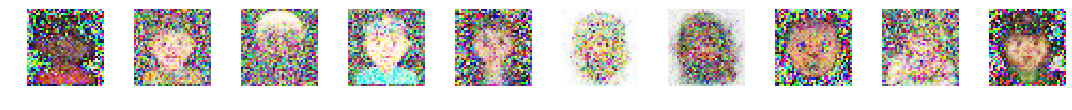

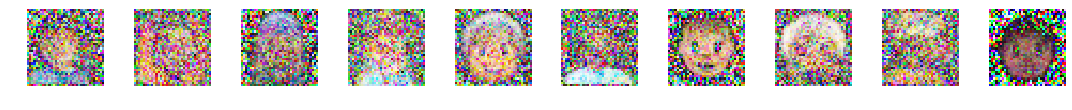

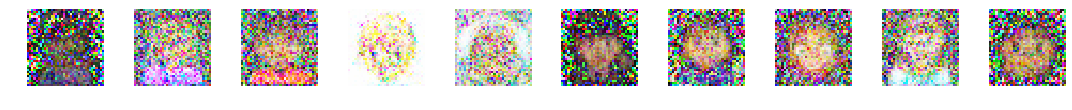

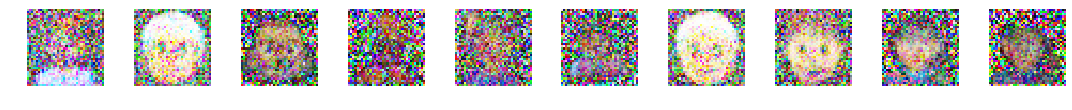

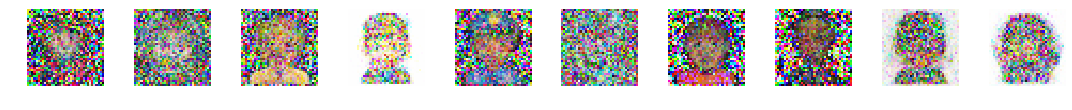

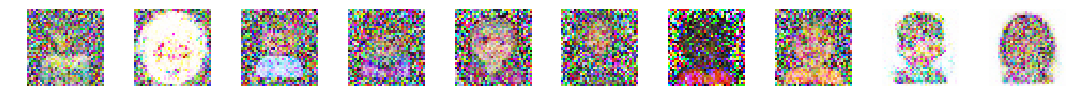

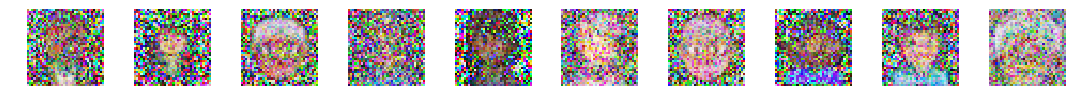

In [70]:
generator, disc_loss, gen_loss = train(epochs=epochs, pretrain_epochs=pretrain_epochs, batch_size=128)

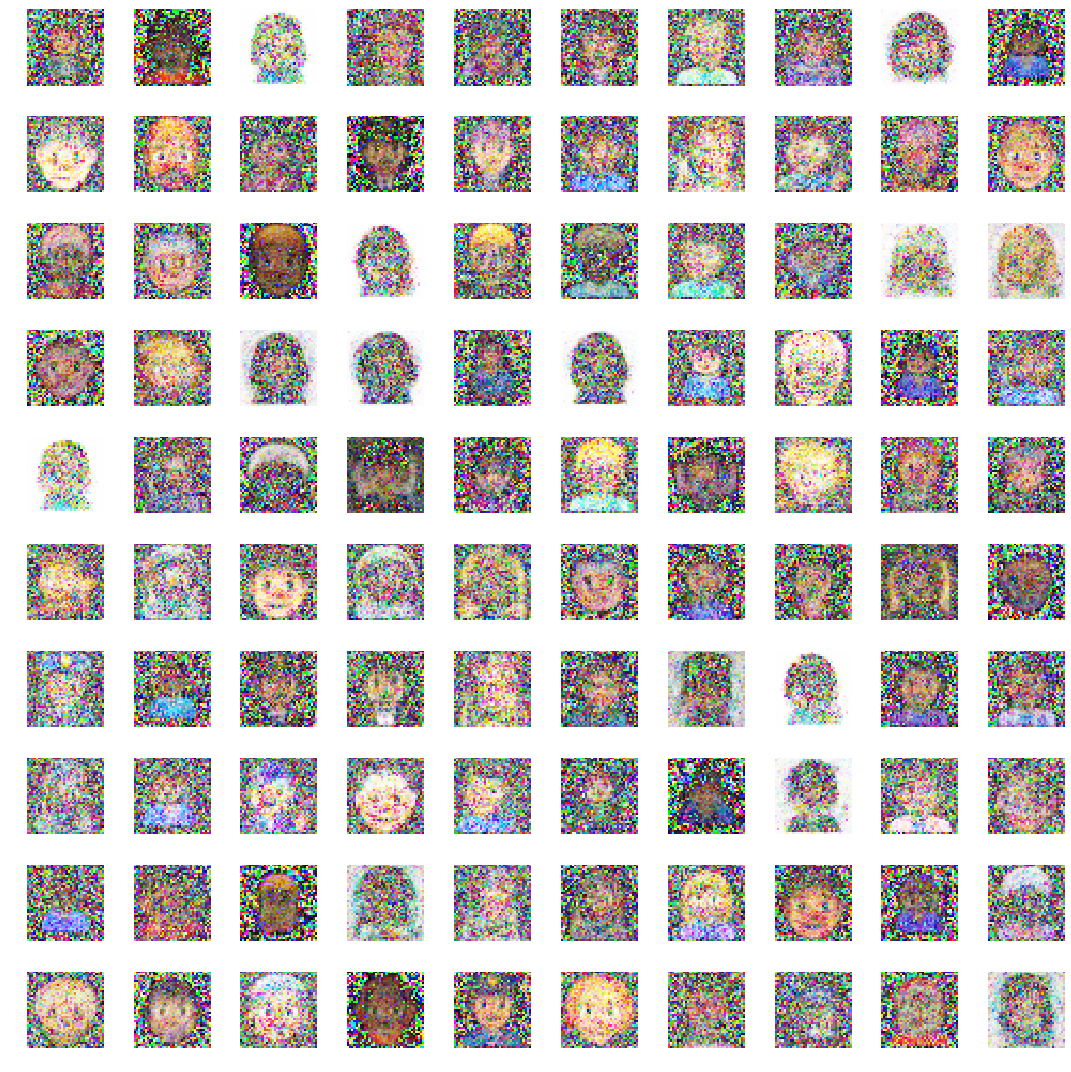

In [71]:
plot_generated_images(epochs, generator, examples=100)

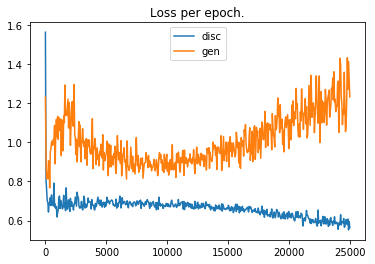

In [72]:
plot_losses(epochs, disc_loss, gen_loss)

In [67]:
from keras.models import load_model

In [ ]:
generator.save('people_generator_200k.h5')

In [ ]:
del generator

In [ ]:
generator = load_model('people_generator_200k.h5')

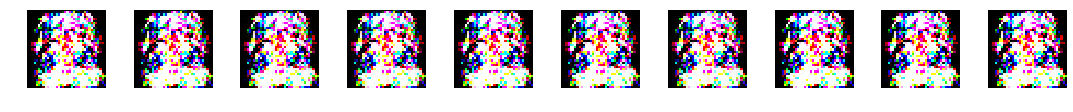

In [76]:
plot_generated_images(epochs, generator)

In [67]:
def gen_images(generator):
    rows = 10
    dim = (10, 10)
    gen = generator(rows)
    for x in range(1, rows + 1):
        generated_images = next(gen)[1]
        generated_images = generated_images.reshape(rows, 36, 36, 3)
        plt.figure(figsize=(10, 10))
        for i in range(rows):
            plt.subplot(dim[0], dim[1], x + i)
            plt.imshow((generated_images[i] * 255).astype(np.uint8), interpolation='nearest')
            plt.axis('off')

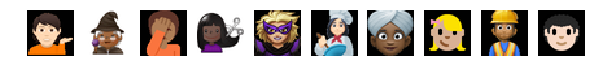

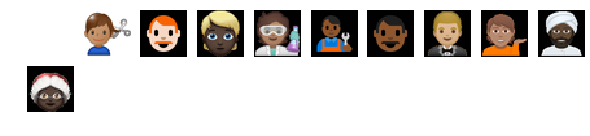

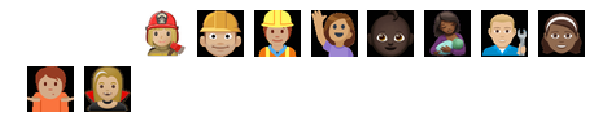

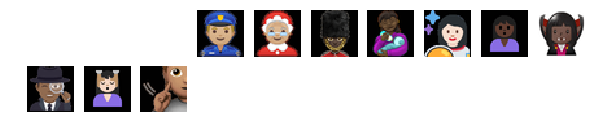

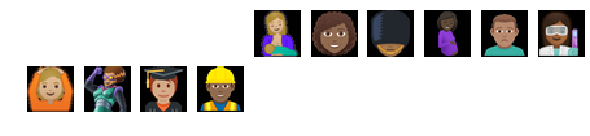

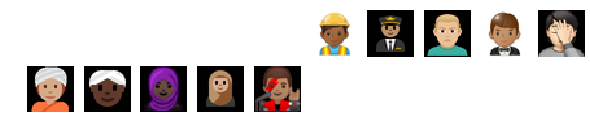

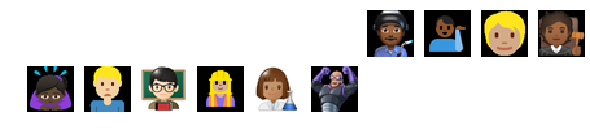

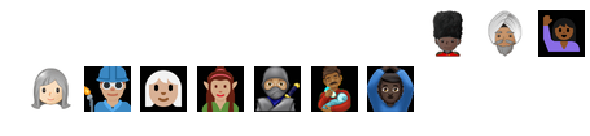

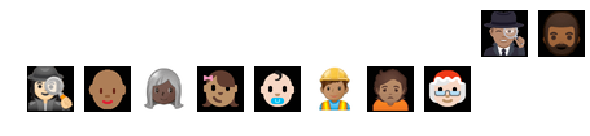

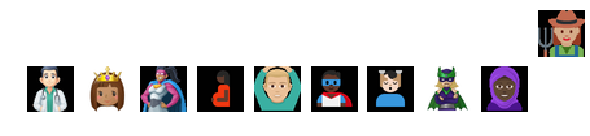

In [68]:
gen_images(generator_batch)